## Практическое задание к уроку № 6 по теме "Сегментация".

*Обучить нейронную сеть на новом датасете, по аналогии с рассмотренным на уроке кодом.*

# Подготовка библиотек

In [1]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

/bin/bash: /home/shkin/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Cloning into 'clothing-co-parsing'...
remote: Enumerating objects: 4234, done.
remote: Total 4234 (delta 0), reused 0 (delta 0), pack-reused 4234
Receiving objects: 100% (4234/4234), 124.59 MiB | 7.36 MiB/s, done.
Resolving deltas: 100% (1100/1100), done.


In [1]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

import matplotlib.pyplot as plt
import os
from scipy import io
from sklearn.model_selection import train_test_split

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Проверить устройства для кераса

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15914673641771382160
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6681788416
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4814882880631081741
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2022-08-05 19:32:16.413427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 19:32:16.413795: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 19:32:16.414056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 19:32:16.414348: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 19:32:16.414712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

# Функции для визуализации

In [5]:
def display(display_list):
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# Загрузка датасета и обработка

In [6]:
DATASET_PATH = 'clothing-co-parsing/photos/'
MASKS_PATH = 'clothing-co-parsing/annotations/pixel-level/'

In [7]:
def preprocess_image(image):
    image = tf.cast(image, tf.float32)
    
    # scale values to [0,1]
    image = image / 255.0
    
    # resize image
    image = tf.image.resize(image, (128,128))
    return image 
     

def preprocess_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    
    # будем использовать бинарную классификацию - фон и человек
    # для этого фон, закодированный нулем, оставим нулевым
    # все остальное будет равно единице
    mask = tf.cast(mask != 0, tf.uint8)
    return mask  

In [8]:
images = []
masks = []

for mask_filename in os.listdir(MASKS_PATH):
    image_filename = mask_filename[:-4] + '.jpg'
    image = img_to_array(load_img(DATASET_PATH + image_filename))
    images.append(preprocess_image(image))
      
    mask_file = io.loadmat(MASKS_PATH + mask_filename)
    mask = tf.convert_to_tensor(mask_file['groundtruth']) 
    masks.append(preprocess_mask(mask))

2022-08-05 19:32:55.431186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 19:32:55.431604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 19:32:55.431872: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 19:32:55.432321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 19:32:55.432592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [9]:
train_X, test_X, train_Y, test_Y = train_test_split(images, masks,\
                                                 test_size=0.2, random_state=0)
sample_image, sample_mask = test_X[5], test_Y[5]

train_X = tf.data.Dataset.from_tensor_slices(train_X)
test_X = tf.data.Dataset.from_tensor_slices(test_X)
train_Y = tf.data.Dataset.from_tensor_slices(train_Y)
test_Y = tf.data.Dataset.from_tensor_slices(test_Y)

train = tf.data.Dataset.zip((train_X, train_Y))
test = tf.data.Dataset.zip((test_X, test_Y)) 

По сравнению с кодом урока, добавим случайности и изменение  
контрастности:

In [10]:
# функции для аугментации 

# яркость
def brightness(img, mask):
    img = tf.image.stateless_random_brightness(img, max_delta=0.2, seed=(29, 29))
    return img, mask

# контрастность
def contrast(img, mask):
    img = tf.image.stateless_random_contrast(img, 0.2, 0.5, seed=(29, 29))
    return img, mask
    
# оттенок
def hue(img, mask):
    img = tf.image.stateless_random_hue(img, max_delta=0.2, seed=(29, 29))
    return img, mask

# отзеркаливание по горизонтали
def flip_horizontal(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

In [11]:
# последовательно применяем аугментации
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(contrast))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(flip_horizontal))

In [12]:
len(train)

12848

In [13]:
BATCH_SIZE = 32
BUFFER_SIZE = 500
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train = train.prefetch(1)
test = test.batch(BATCH_SIZE) 

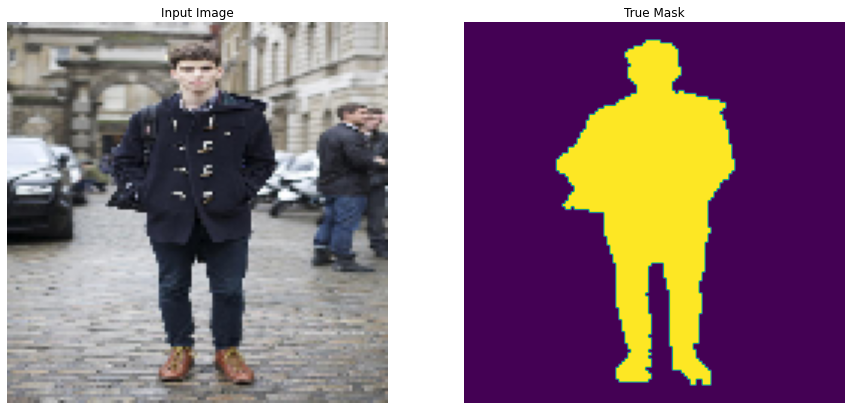

In [14]:
display([sample_image, sample_mask])

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64x96
    'block_3_expand_relu',   # 32x32x144
    'block_6_expand_relu',   # 16x16x192
    'block_13_expand_relu',  # 8x8x576
    'block_16_project',      # 4x4x320
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [16]:
up_stack = [
    tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu')
]

In [17]:
def resolution_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

  # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, 
                                           padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

# Обучение

Подберём оптимальную величину learning rate, используя callback:

In [18]:
OUTPUT_CHANNELS = 2
tf.random.set_seed(29)
EPOCHS = 10

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 5e-5 * 10**(epoch / 3))

model = resolution_model(OUTPUT_CHANNELS)


model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train, epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test,
                    callbacks=[lr_schedule])

Epoch 1/10


2022-08-05 19:33:19.584976: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-05 19:33:19.945322: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


402/402 [==============================] - 18s 37ms/step - loss: 0.2622 - accuracy: 0.8766 - val_loss: 0.1331 - val_accuracy: 0.9471 - lr: 5.0000e-05
Epoch 2/10
402/402 [==============================] - 14s 34ms/step - loss: 0.1116 - accuracy: 0.9547 - val_loss: 0.1038 - val_accuracy: 0.9593 - lr: 1.0772e-04
Epoch 3/10
402/402 [==============================] - 14s 34ms/step - loss: 0.0889 - accuracy: 0.9642 - val_loss: 0.0863 - val_accuracy: 0.9668 - lr: 2.3208e-04
Epoch 4/10
402/402 [==============================] - 14s 35ms/step - loss: 0.0686 - accuracy: 0.9729 - val_loss: 0.0763 - val_accuracy: 0.9723 - lr: 5.0000e-04
Epoch 5/10
402/402 [==============================] - 14s 34ms/step - loss: 0.0570 - accuracy: 0.9775 - val_loss: 0.0791 - val_accuracy: 0.9726 - lr: 0.0011
Epoch 6/10
402/402 [==============================] - 14s 34ms/step - loss: 0.0884 - accuracy: 0.9654 - val_loss: 0.0820 - val_accuracy: 0.9705 - lr: 0.0023
Epoch 7/10
402/402 [==============================] -

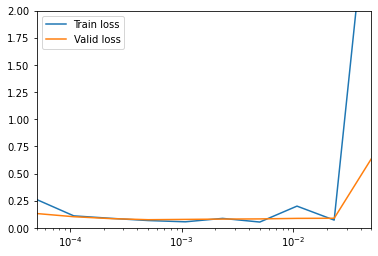

In [19]:
plt.semilogx(history.history["lr"], history.history["loss"], label='Train loss')
plt.semilogx(history.history["lr"], history.history["val_loss"], label='Valid loss')
plt.axis([5e-5, 5e-2, 0, 2])
plt.legend()
plt.show()

Исходя из графика, выберем значение 0,001.

Epoch 1/10
401/402 [============================>.] - ETA: 0s - loss: 0.5759 - accuracy: 0.7947

Sample Prediction after epoch 1:

1/1 [==============================] - 1s 646ms/step


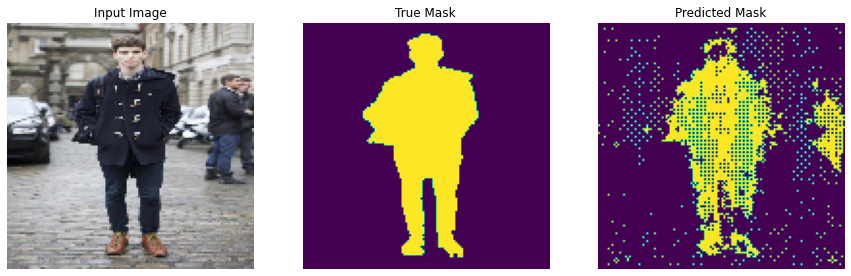

402/402 [==============================] - 17s 38ms/step - loss: 0.5755 - accuracy: 0.7948 - val_loss: 0.2389 - val_accuracy: 0.8969
Epoch 2/10
402/402 [==============================] - 14s 35ms/step - loss: 0.1920 - accuracy: 0.9111 - val_loss: 0.1846 - val_accuracy: 0.9220
Epoch 3/10
402/402 [==============================] - 14s 34ms/step - loss: 0.1551 - accuracy: 0.9290 - val_loss: 0.1392 - val_accuracy: 0.9528
Epoch 4/10
402/402 [==============================] - 14s 34ms/step - loss: 0.1016 - accuracy: 0.9604 - val_loss: 0.1039 - val_accuracy: 0.9621
Epoch 5/10
402/402 [==============================] - 14s 34ms/step - loss: 0.0903 - accuracy: 0.9645 - val_loss: 0.0938 - val_accuracy: 0.9654
Epoch 6/10
401/402 [============================>.] - ETA: 0s - loss: 0.0850 - accuracy: 0.9666

Sample Prediction after epoch 6:

1/1 [==============================] - 0s 13ms/step


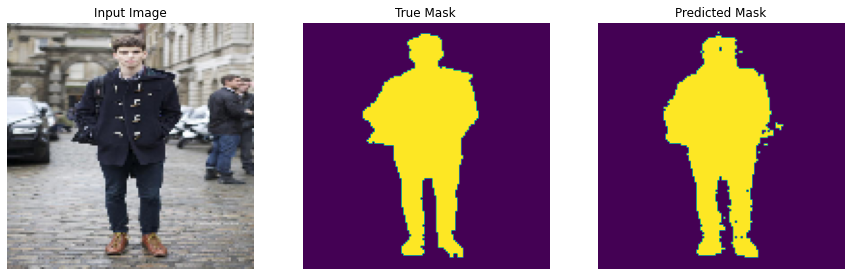

402/402 [==============================] - 14s 34ms/step - loss: 0.0850 - accuracy: 0.9666 - val_loss: 0.0921 - val_accuracy: 0.9667
Epoch 7/10
402/402 [==============================] - 14s 35ms/step - loss: 0.0816 - accuracy: 0.9679 - val_loss: 0.0909 - val_accuracy: 0.9670
Epoch 8/10
402/402 [==============================] - 14s 34ms/step - loss: 0.0786 - accuracy: 0.9691 - val_loss: 0.0904 - val_accuracy: 0.9673
Epoch 9/10
402/402 [==============================] - 14s 34ms/step - loss: 0.0763 - accuracy: 0.9700 - val_loss: 0.0934 - val_accuracy: 0.9659
Epoch 10/10
401/402 [============================>.] - ETA: 0s - loss: 0.0743 - accuracy: 0.9707

Final Prediction:

1/1 [==============================] - 0s 14ms/step


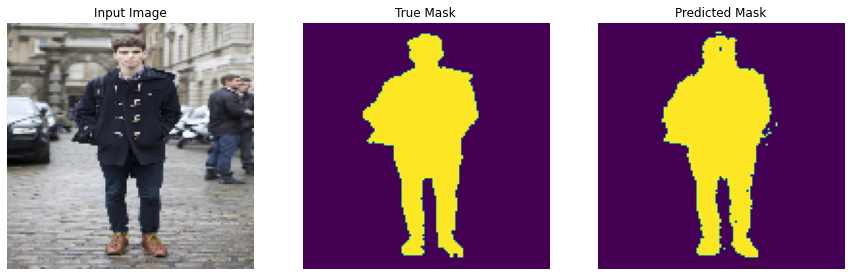

402/402 [==============================] - 14s 34ms/step - loss: 0.0743 - accuracy: 0.9707 - val_loss: 0.0898 - val_accuracy: 0.9678


In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if not epoch % 5:
            print ('\n\nSample Prediction after epoch {}:\n'.format(epoch+1))
            show_predictions(model)
    
        if epoch == EPOCHS - 1:
            print('\n\nFinal Prediction:\n')
            show_predictions(model)

tf.random.set_seed(29)        
EPOCHS = 10

model = resolution_model(OUTPUT_CHANNELS)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train, epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=test,
                    callbacks=[DisplayCallback()])
loss = history.history['loss']
val_loss = history.history['val_loss']

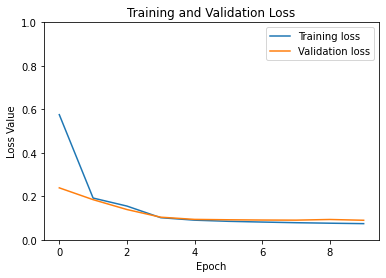

In [21]:
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

Протестируем нейронную сеть на других изображениях из валидационной части:

1/1 [==============================] - 0s 17ms/step


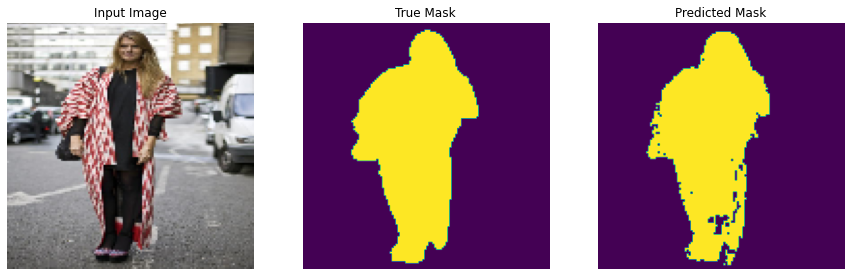

1/1 [==============================] - 0s 17ms/step


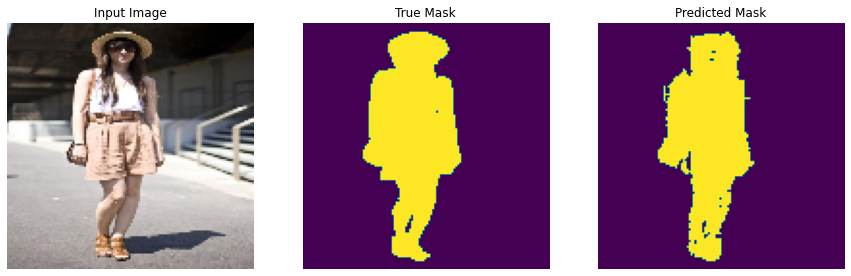

1/1 [==============================] - 0s 15ms/step


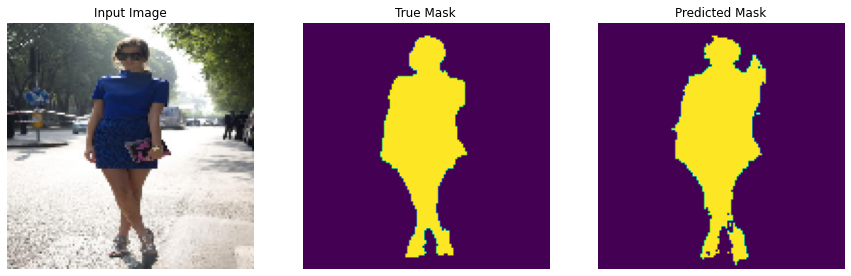

In [22]:
show_predictions(model, test, 3)

<ins>Вывод:</ins>  
Обучили нейронную сеть на новом датасете по аналогии с работой  
на уроке. Исходный датасет содержит 59 классов, на которые можно  
сегментировать изображение. Здесь мы использовали только 2.  
Попытка использовать 59 классов не увенчалась успехом, так как  
в датасете всего около 1000 размеченных изображений, каждое из которых  
содержит не более 10 классов. В обучающей выборке до аугментации было  
всего около 800 изображений. Таким образом, для нормального обучения  
нейросети не хватало обучающих примеров, а на имеющихся модель быстро  
переобучалась, т.к. она запоминала обучающую выборку. Результативность  
предсказаний на тестовой выборке оставляла желать лучшего.  
В целом, наша финальная модель довольно неплохо научилась очерчивать  
силуэты людей на изображении.